# Necessary Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Reading the data

In [2]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
user_data = pd.read_csv('ml-100k/u.data', sep = '\t',names = columns)
movie_data = pd.read_csv('ml-100k/u.item', delimiter = '|', encoding = 'ISO-8859-1',header = None)
movie_data = movie_data.ix[:,:1]
movie_data.columns = ['item_id','movie_name']
movie_data_genre = pd.read_csv('ml-100k/u.item', delimiter = '|', encoding = 'ISO-8859-1',header = None)

# Getting Movie Genre List

In [3]:
movie_data_genre = movie_data_genre.ix[ :,5:]
movie_data_genre.columns = ['unknown','Action' , 'Adventure','Animation',
              "Children's",'Comedy','Crime' ,'Documentary','Drama','Fantasy',
              'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
              'Thriller','War','Western']

# Appending movie genre list into the  dataframe

In [4]:
movie_data_genre.index = range(1,len(movie_data_genre.index)+1)
genre_movie = []
genre =[]
c=1
for i in movie_data_genre:
    for j in movie_data_genre[i]:
        c += 1
        if j == 1:
            genre_movie.append(c)
    genre.append(genre_movie)
    genre_movie = []
    c=1
genre_list = []
genres = []
genre_dict ={}
for i,k in zip(genre,movie_data_genre.columns):
        genre_dict[k] = i
genre_final = {}
lst = []
for i in range(1,len(movie_data_genre)+1):
    for key,value in genre_dict.items():
        for j in value:
            if j == i:
                lst.append(key)
    if lst == []:
        genre_final[i] = 'unknown'
    else:
        el = ''
        for l in lst:
            el += l + ' '
        genre_final[i] = el      
    lst = []          

In [5]:
movie_genre = pd.DataFrame() 
movie_genre = movie_genre.from_dict(genre_final,orient='index')
movie_genre.columns = ['genre']
movie_genre.index = range(0,len(movie_genre))

In [6]:
movie_data = movie_data.join(movie_genre , on='item_id')

In [7]:
movie_data.head()

,item_id,movie_name,genre
0,1,Toy Story (1995),Comedy Children's Animation
1,2,GoldenEye (1995),Adventure Thriller Action
2,3,Four Rooms (1995),Thriller
3,4,Get Shorty (1995),Comedy Action Drama
4,5,Copycat (1995),Thriller Crime Drama


# Knowing the data

In [8]:
n_users = user_data.user_id.unique().shape[0]
n_items = user_data.item_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 943 | Number of movies = 1682


# Converting data into matrix

In [9]:
data_matrix = np.zeros((n_users, n_items))
for line in user_data.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]  

# Finding cosine similarity

In [10]:
user_similarity = 1 - pairwise_distances(data_matrix, metric='cosine')
item_similarity = 1 - pairwise_distances(data_matrix.T, metric='cosine')

# Creating a Rating_table

In [11]:
rating_table = pd.pivot_table(user_data, values='rating', index=['user_id'],columns=['item_id'])

# Calculating mean of rating (user-wise and item_wise)

In [12]:
rating_table.fillna(value = 0 , inplace = True)
mean_user_rating = rating_table.mean(axis = 1)
mean_item_rating = rating_table.mean(axis =0)

# Defining a K-Nearest Neighbor function

In [13]:
def knn(similarity,k = 10):
    similarity = pd.DataFrame(similarity)
    similarity.index = range(1,len(similarity)+1)
    similarity.columns = range(1,len(similarity)+1)
    lst = [] 
    item_list = []
    lst1 = []
    x, y = similarity.shape
    for i in similarity:
        u_d = similarity.ix[i]
        u_d = u_d.sort_values(ascending = False)
        u = pd.DataFrame(u_d.head(k+1))
        u.reset_index(inplace = True)
        u.columns = ['id','similarity']
        lst.append(u.id.tolist())
        ret = np.array(lst)
    return ret

# Defining a Prediction function for K nearest neighbors

In [14]:
def prediction_biased(ratings, similarity,k = 10,type = 'user'):
    pred = np.zeros(ratings.shape)
    if type == 'user':
        lst = knn(similarity,k)
        similarity = pd.DataFrame(similarity)
        similarity.index = range(1,len(similarity)+1)
        similarity.columns = range(1,len(similarity)+1)
        for i in range(ratings.shape[0]):
            u = lst[i][0]
            for j in range(ratings.shape[1]):
                similar_users = lst[i][1:]
                u_mean = mean_user_rating.ix[u]
                sum1= 0
                simsum = 0
                if ratings[i][j] == 0:
                    for v in range(len(similar_users)):
                        neigh = similar_users[v]
                        neigh_mean =  mean_user_rating.ix[neigh]
                        sim = similarity[u][neigh]
                        rat = rating_table.ix[neigh,j+1]
                        rating_diff = rat - neigh_mean
                        sum1 += sim * rating_diff
                        simsum += sim
                    pred[i,j] = u_mean + sum1/simsum
    if type == 'item':
        lst = knn(similarity,k)
        similarity = pd.DataFrame(similarity)
        similarity.index = range(1,len(similarity)+1)
        similarity.columns = range(1,len(similarity)+1)
        for i in range(ratings.shape[1]):
            u = lst[i][0]
            for j in range(ratings.shape[0]):
                similar_items = lst[i][1:]
                u_mean = mean_item_rating.ix[u]
                sum1 = 0
                simsum = 0
                if ratings[j][i] == 0:
                    for v in range(len(similar_items)):
                        neigh = similar_items[v]
                        neigh_mean = mean_item_rating.ix[neigh]
                        sim = similarity[u][neigh]
                        rat = rating_table.ix[j+1, neigh]
                        rating_diff = rat - neigh_mean
                        sum1 += sim * rating_diff
                        simsum += sim
                    pred[j,i] = u_mean + sum1/simsum
                
    return pred

# Calling user-item pediction function

In [ ]:
user_prediction = prediction_biased(data_matrix, user_similarity, type='user',k = 10)

# Caling item-item prediction function

In [ ]:
item_prediction = prediction_biased(data_matrix, item_similarity, type='item',k = 10)

# Converting matrix into DataFrame

In [ ]:
u_predict = pd.DataFrame(user_prediction)
i_predict = pd.DataFrame(item_prediction)

# Printing User-Item prediction Rating

In [39]:
u_predict.index = range(1,944)
u_predict.columns = range(1,1683)
u_predict.columns = movie_data.movie_name.tolist()
u_predict.head()

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),...,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.137548,-0.137548,-0.137548,-0.137548,-0.137548,-0.137548,-0.137548,-0.137548,-0.137548,0.179799
2,0.000000,-0.009293,0.469565,-0.009293,-0.009293,0.366053,2.103975,-0.009293,2.882656,0.000000,...,-0.009293,-0.009293,-0.009293,-0.009293,-0.009293,-0.009293,-0.009293,-0.009293,-0.009293,-0.009293
3,-0.033077,-0.033077,-0.033077,-0.033077,-0.033077,-0.033077,-0.033077,-0.033077,-0.033077,-0.033077,...,-0.033077,-0.033077,-0.033077,-0.033077,-0.033077,0.071971,0.282067,0.177019,-0.033077,-0.033077
4,-0.026085,-0.026085,-0.026085,-0.026085,-0.026085,-0.026085,-0.026085,-0.026085,-0.026085,-0.026085,...,-0.026085,-0.026085,-0.026085,-0.026085,-0.026085,0.069255,0.259936,0.164595,-0.026085,-0.026085
5,0.000000,0.000000,0.530272,2.313243,0.243456,-0.169787,3.008860,0.932118,0.327618,0.612112,...,-0.169787,-0.169787,-0.169787,-0.169787,-0.169787,-0.169787,-0.169787,-0.169787,-0.169787,-0.169787


# Printing Item-Item prediction Rating

In [40]:
i_predict.index = range(1,944)
i_predict.columns = range(1,1683)
i_predict.columns = movie_data.movie_name.tolist()
i_predict.head()

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),...,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.129562,-0.081495,-0.025971,-0.025971,-0.050508,-0.013023,-0.013023,-0.013023,-0.013368,-0.041231
2,0.000000,-0.178266,-0.250947,-0.587993,-0.341219,0.352383,1.239781,-0.455687,2.374202,0.000000,...,-0.129562,0.161772,-0.025971,-0.025971,-0.050508,-0.013023,-0.013023,-0.013023,-0.013368,-0.041231
3,0.527663,-0.178266,-0.250947,-0.587993,-0.341219,-0.028701,0.173250,-0.455687,-0.402125,-0.388790,...,-0.129562,-0.081495,0.043391,0.043391,-0.050508,-0.013023,-0.013023,-0.013023,-0.013368,-0.041231
4,0.660320,-0.178266,-0.250947,-0.587993,-0.341219,-0.028701,0.293884,-0.455687,0.077312,-0.388790,...,-0.129562,-0.081495,-0.025971,-0.025971,-0.050508,0.349701,0.349701,0.349701,-0.013368,-0.041231
5,0.000000,0.000000,1.439409,1.601595,0.649494,-0.028701,2.887082,2.462425,1.217198,0.070559,...,-0.046278,-0.081495,-0.025971,-0.025971,-0.050508,-0.013023,-0.013023,-0.013023,-0.013368,-0.041231


# Defining a method to recommend movies to user

In [83]:
def recommend(user_id):
    alpha1 = user_prediction[user_id]
    movie_ = []
    rating_ =[]
    movie_id =[]
    genre = []
    for k in alpha1.nonzero():
        movie_.append(movie_data.movie_name[k])
        rating_.append(alpha1[alpha1.nonzero()])
        movie_id.append(k)
        genre.append(movie_data.genre[k])
    movie_names = pd.DataFrame(movie_).T
    rating_ = pd.DataFrame(rating_).T
    movie_id = pd.DataFrame(movie_id).T
    movie_genre = pd.DataFrame(genre).T 
    movie_genre.reset_index(inplace= True)
    movie_genre.drop(['index'],axis =1,inplace= True)
    movie_names.reset_index(inplace = True)
    movie_names.drop(['index'],axis = 1,inplace= True)
    movie_names = movie_names.join(rating_)
    movie_names = movie_names.join(movie_id,rsuffix='_x')
    movie_names = movie_names.join(movie_genre)
    movie_names.columns = ['movie','pred_rating','movie_id','genre']
    movie_names.sort_values(by =['pred_rating'],ascending= False,inplace= True)
    recommended = pd.DataFrame(movie_names.head(10))
    return recommended

# Testing the recommendation model

In [84]:
recommend = recommend(1)
recommend

,movie,pred_rating,movie_id,genre
114,Lone Star (1996),3.121669,123,Mystery Drama
170,Return of the Jedi (1983),3.072577,180,Adventure Sci-Fi Action War Romance
7,Dead Man Walking (1995),2.882656,8,Drama
452,"Boot, Das (1981)",2.838558,514,Action Drama War
270,"Game, The (1997)",2.399017,332,Thriller Mystery
681,Michael Collins (1996),2.262164,743,Drama War
627,Seven Years in Tibet (1997),2.225163,689,Drama War
687,Amistad (1997),2.107137,749,Drama
5,Twelve Monkeys (1995),2.103975,6,Sci-Fi Drama
232,"Devil's Own, The (1997)",2.055677,244,Thriller Action Drama War


In [85]:
recommend_graph = recommend.drop(['movie_id','genre'],axis = 1)
movie_list = recommend.movie.tolist()
recommend_graph.reset_index(inplace= True)
recommend_graph = recommend_graph.drop(['index'],axis = 1)
recommend_graph = recommend_graph.set_index(['movie'])
recommend_graph

,pred_rating
movie,
Lone Star (1996),3.121669
Return of the Jedi (1983),3.072577
Dead Man Walking (1995),2.882656
"Boot, Das (1981)",2.838558
"Game, The (1997)",2.399017
Michael Collins (1996),2.262164
Seven Years in Tibet (1997),2.225163
Amistad (1997),2.107137
Twelve Monkeys (1995),2.103975


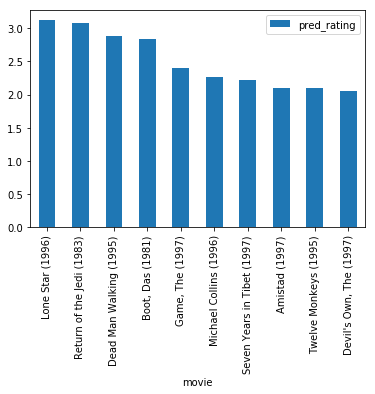

In [86]:
recommend_graph.plot(kind = 'bar',legend = movie_list)
plt.show()

In [77]:
def watched(user_id):
    alpha1 = data_matrix[user_id]
    movie_ = []
    rating_ =[]
    movie_id =[]
    genre = []
    for k in alpha1.nonzero():
        movie_.append(movie_data.movie_name[k])
        rating_.append(alpha1[alpha1.nonzero()])
        movie_id.append(k)
        genre.append(movie_data.genre[k])
    movie_names = pd.DataFrame(movie_).T
    rating_ = pd.DataFrame(rating_).T
    movie_id = pd.DataFrame(movie_id).T
    movie_genre = pd.DataFrame(genre).T 
    movie_genre.reset_index(inplace= True)
    movie_genre.drop(['index'],axis =1,inplace= True)
    movie_names.reset_index(inplace = True)
    movie_names.drop(['index'],axis = 1,inplace= True)
    movie_names = movie_names.join(rating_)
    movie_names = movie_names.join(movie_id,rsuffix='_x')
    movie_names = movie_names.join(movie_genre)
    movie_names.columns = ['movie','given_rating','movie_id','genre']
    movie_names.sort_values(by =['given_rating'],ascending= False,inplace= True)
    watch = pd.DataFrame(movie_names.head(10))
    return watch

In [87]:
watch = pd.DataFrame()
watch = watched(1)
watched_graph = watch.drop(['movie_id','genre'],axis = 1)
movie_list = watch.movie.tolist()
watched_graph.reset_index(inplace= True)
watched_graph = watched_graph.drop(['index'],axis = 1)
watched_graph = watched_graph.set_index(['movie'])
watched_graph

,given_rating
movie,
As Good As It Gets (1997),5.0
"Godfather, The (1972)",5.0
Secrets & Lies (1996),5.0
Sense and Sensibility (1995),5.0
Good Will Hunting (1997),5.0
Shall We Dance? (1996),5.0
Kolya (1996),5.0
L.A. Confidential (1997),5.0
Emma (1996),5.0


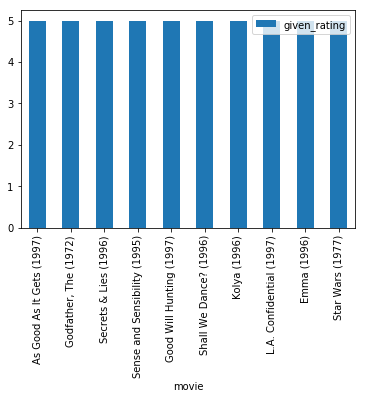

In [88]:
watched_graph.plot(kind = 'bar',legend = movie_list)
plt.show()